In [462]:
#importing libraries
import pandas as pd
import numpy as np
from warnings import simplefilter
simplefilter("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import chardet #evaluate encoding of csv
from keybert import KeyBERT
import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords        
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
nltk.download("vader_lexicon") # load the Lexicon that quantifies polar sentiment (positive/negative)

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [463]:
# look at the first ten thousand bytes to guess the character encoding
with open("train.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

# check what the character encoding might be
print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [464]:
df_train = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")

# EDA

In [465]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [466]:
df_train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613.0,NaN,NaN,NaN,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613.0,NaN,NaN,NaN,0.42966,0.49506,0.0,0.0,0.0,1.0,1.0


In [467]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


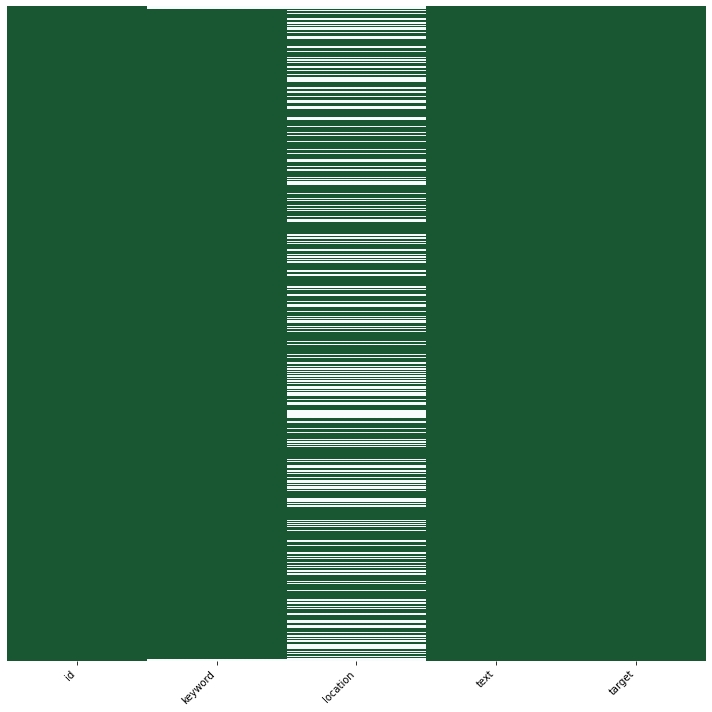

In [468]:
#visualize the missing values
ax, fig = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train.isna(),yticklabels=False,cbar=False,cmap='BuGn_r', alpha = 0.9)

plt.xticks(rotation = 45, ha="right")

plt.tight_layout()

#note that low number of missings won't show in the chart

## ID

In [469]:
df_train["id"]
#ID is not apporting any info we will drop it

0           1
1           4
2           5
3           6
4           7
        ...  
7608    10869
7609    10870
7610    10871
7611    10872
7612    10873
Name: id, Length: 7613, dtype: int64

## Keyword

In [470]:
df_train["keyword"].describe()
#fatalities is the most used keywords - we have 221 different keywords

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [471]:
#has some nan values
df_train["keyword"].isna().value_counts(normalize=True)
# 0.8% (61) are missing - we will proceed imputing these values using KeyBERT

False    0.991987
True     0.008013
Name: keyword, dtype: float64

To avoid data leakage we need to train test split the data first and then create the list of unique keywords from the train set.

Let's go forward keeping analyzing the data and then we will build a function to tranform the Keyword column. Let's have a look at the kind of keywords we are dealing with:

In [472]:
df_train[~df_train["keyword"].isna()]["keyword"].unique().tolist()[:30] #remove this slicing to analyze all the keywords

['ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'de

We can see that most of the spaces are wrongly encoded with %20. Also, there are words that are similar, we will take care of them when dealing with the text feature.

## Text

In [473]:
df_train["text"].values.tolist()[:30] #remove this slicing to analyze all the keywords

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

As we can see here we have different porblems:
1. There are a multitude of links. We don't need them but we will create a new feature "has_link"
2. Some words have been encoded incorrectly eg. \x89Ûªt
3. Tabs and escape need to be removed
4. People tags are not useful. We will take them out and add a new feature "has_tag"
5. Ashtags will be removed. We will create a new feature "ashtags" that we will then merge with the keyword feature creating "keyword+". Also we will normalize the keywords using stemming
6. We will create in the end a new feature based on the sentiment score using the compound value
7. After we will normalize the text applying punctuation and stopwrods removal and stemming


## Location

In [474]:
df_train["location"]
#lots of values missing

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
7608    NaN
7609    NaN
7610    NaN
7611    NaN
7612    NaN
Name: location, Length: 7613, dtype: object

In [475]:
df_train["location"].isna().value_counts(normalize=True)*100
#33%  missing locations

False    66.727965
True     33.272035
Name: location, dtype: float64

In [476]:
df_train[~df_train["location"].isna()]["location"].values.tolist()[:30] #remove this slicing to analyze all the keywords

['Birmingham',
 'Est. September 2012 - Bristol',
 'AFRICA',
 'Philadelphia, PA',
 'London, UK',
 'Pretoria',
 'World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'Live On Webcam',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja',
 'USA',
 'South Africa',
 'Sao Paulo, Brazil',
 'hollywoodland ',
 'Edmonton, Alberta - Treaty 6',
 'Inang Pamantasan',
 'Twitter Lockout in progress',
 'Concord, CA',
 'Calgary, AB',
 'Birmingham',
 'San Francisco',
 'CLVLND',
 'Nashville, TN',
 'Santa Clara, CA',
 'UK',
 'St. Louis, MO',
 'Walker County, Alabama',
 'Australia',
 'North Carolina',
 'Norf Carolina',
 'San Mateo County, CA',
 'North Carolina',
 'Njoro, Kenya',
 "Your Sister's Bedroom",
 'Arlington, TX',
 'South Bloomfield, OH',
 'New Hanover County, NC',
 'Maldives',
 'Manchester, NH',
 'Wilmington, NC',
 'New Hanover County, NC',
 'global',
 'Alberta | Sask. | Montana',
 'Charlotte',
 'Baton Rouge, LA',
 'Hager

More than 15% of values are missing and not very useful information from this feature - we will drop it and create a new feature "has_location"

## Target

In [477]:
df_train["target"].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

In [478]:
df_train["target"].value_counts(normalize=True)*100
#42% are disaster

0    57.034021
1    42.965979
Name: target, dtype: float64

# Feature Transformation and Engineering

In [479]:
#splitting data
y = df_train["target"]
# X.drop("target", axis=1, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop("target", axis=1), y, test_size=0.25, random_state=42)

In [480]:
def keyword_extractor(text):
    """
    This function extracts keywords from text using KeyBERT
    
    It ueses a list keywords candidates where to chose from.
    Maximal Marginal Relevance (MMR) set to True
    Diversity is set to 0.2
    Top n keywords/keyphrases is set to 6
    
    Args:
        text (str): text to porcess

    Returns:
        list: list of keywords
    """
    

    keywords = kw_model.extract_keywords(
        text, keyphrase_ngram_range=(1,1),
        stop_words="english",
        candidates=kwd_list,
        use_mmr=True,
        diversity=0.2,
        top_n=1
        )
    
    return "".join([str(i[0]) for i in keywords])

In [481]:
def location_transformer(df):
    """
    Creating new feature "has_location"
    """
    
    df["has_location"] = np.where(df["location"].isna(), 0,1)
    

In [482]:
    #to avoid leaking we'll use X_train to make the unique keywords list
    global kwd_list
    kwd_list = X_train["keyword"].unique().tolist() 
    kwd_list.remove(np.nan) #removing nan value from the list
    
    #removing %20 from the list and substituting with a space
    pattern="%20"
    regex = re.compile(pattern)
    kwd_list = [regex.sub(" ", i) if "%20" in i else i for i in kwd_list]

In [483]:
def kwd_transformer(df):
    """
    1. Removing %20 from keywords
    2. Imputing missing keywords with keyBERT
    3. Changing wild fire to wildfires
    """
    
    #removing space encoding
    df["keyword"] = df["keyword"].str.replace("%20", " ")
    print("removed space encoding")
    
    #imputing missing keywords
    
    global kw_model
    kw_model = KeyBERT()
    
    df["keyword"] = df.apply(lambda x: keyword_extractor(x["text"]) if x["keyword"] is np.nan else x["keyword"], axis=1)
    print("Imputed missing Keywords")
    
    #making wildfires an unique word
    df["keyword"] = df["keyword"].apply(lambda x: "wildfires" if x=="wild fires" else x)
    print("made 'wild fires'=='wildfires' ")
    


In [484]:
def polarity(row):
    """
    Creating Polarity score feature
    """
    
    pol = analyzer.polarity_scores(row)
    compound = pol["compound"]
    
    return pd.Series([compound])

In [485]:
def text_transformer(df):
    """
    1. Removing links form text and creating a feature "has_link"
    2. Creating a text length feature and binning it in 2 chunks - 
        this is because short text tweets are more prone to have target 1
    3. Creating a "has_hastag" feature. We will then remove "#" from text and merge the ashtags
        in a unique feature with keywords and stem it
    4. Removing all the tags from the text and creating a feature "has_tag"
    5. Removing all tabs characters from the thext
    6. Creating a compound sentiment feature
    """
    
    # 1------LINKS
    #creating new feature has_link
    #creating the regex link pattern
    link_pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)"
    link = re.compile(link_pattern)
    
    #creating feature
    df["has_link"] = df["text"].str.contains(link, regex=True).astype(int)
    
    #removing links from the text
    df["text"] = df["text"].str.replace(link,"", regex=True)
    
    print("links done")
    
    # 2--------LENGHT
    #creating new feature text_len
    df["text_len"] = df["text"].apply(lambda x: len(x))
    
    #creating 5 bins for the lenght
    df["text_len_bins"] = pd.cut(df['text_len'].astype(int), 2) #140chr / 2
    #encoding the bins
    label = LabelEncoder()
    df["text_len_bins"] = label.fit_transform(df["text_len_bins"])
    
    print("len done")
    
    # 3-------ASHTAGS
    #creating ashtag has ashtag feature and ashtags feature
    #ashtags pattern
    ashtag_pattern = r"#(\w+)"
    ashtag = re.compile(ashtag_pattern)
    
    #create feature if it has hashtags
    df["has_ashtags"] = df["text"].str.contains(ashtag, regex=True).astype(int)
    
    #create ashtags feature
    df["ashtags"] = df["text"].apply(lambda x: re.findall(ashtag, x.lower()))
    
    #merging keywords and ashtags
    df["keyword+"] = df.apply(lambda x: [x["keyword"]]+x["ashtags"] if x["keyword"] not in x["ashtags"] else x["ashtags"],axis=1) #removing duplicates and merging columns
    
    df["keyword+"] = df["keyword+"].apply(lambda x: " ".join(x))
    
    #stemming keywords
    global stemmer
    stemmer = PorterStemmer()
    df["keyword+"] = df["keyword"].apply(lambda x : stemmer.stem(x))
    
    #replace ashtag with word without #
    df["text"] = df["text"].str.replace("#","", regex=False)
    
    print("ashtags done")
    
    # 4-------TAGS
    #creating has_tag feature
    
    #tag pattern
    tag_pattern = r"@(\w+)"
    tag = re.compile(tag_pattern)
    
    #add has tag
    df["has_tag"] = df["text"].str.contains(tag, regex=True).astype(int)
    
    #remove all @person from the text feature
    df["text"] = df["text"].str.replace(tag,"", regex=True)
    
    print("tags done")
    
    # 5------\n
    #replacing \n
    df["text"] = df["text"].str.replace("\n"," ", regex=False)
    
    # 6-------SENTIMENT SCORE
    #add sentiment compound feature
    global analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    df["compound"] = df.apply(lambda row: polarity(row["text"]), axis=1)
    
    print("sentiment done")
    

In [486]:
kwd_transformer(X_train)
text_transformer(X_train)
location_transformer(X_train)

removed space encoding
Imputed missing Keywords
made 'wild fires'=='wildfires' 
links done
len done
ashtags done
tags done
sentiment done


In [487]:
df=pd.concat([X_train,y_train], axis=1)
df.head()

,id,keyword,location,text,has_link,text_len,text_len_bins,has_ashtags,ashtags,keyword+,has_tag,compound,has_location,target
5151,7345,obliterate,"Dover, DE",This makes sense. Paper beats rock paper com...,0,136,1,0,[],obliter,1,-0.2960,1,0
6351,9081,structural failure,"ÌÏT: 27.9136024,-81.6078532",': The causes of federal failure are deeply st...,1,106,1,0,[],structural failur,1,-0.7311,1,0
3443,4920,exploded,"Elmwood Park, NJ",Well as I was chaning an iPad screen it fuckin...,0,137,1,0,[],explod,0,0.5574,1,0
7164,10265,war zone,Host of #MindMoversPodcast,the war on drugs has turned the U.S. into a WA...,0,53,0,0,[],war zon,0,-0.8602,1,1
7037,10083,typhoon,NaN,Obama Declares Disaster for Typhoon-Devastated...,0,53,0,0,[],typhoon,0,-0.6249,0,1


<AxesSubplot:xlabel='text_len', ylabel='Count'>

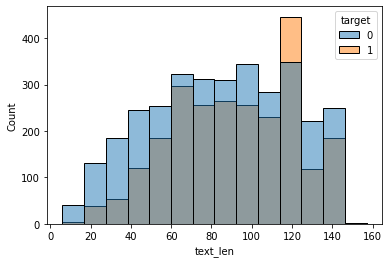

In [488]:
sns.histplot(data=df, x="text_len", hue="target", bins=14) 
#we can see a distinction between text shorter than 60 chars being less frequent

<AxesSubplot:xlabel='target', ylabel='text_len'>

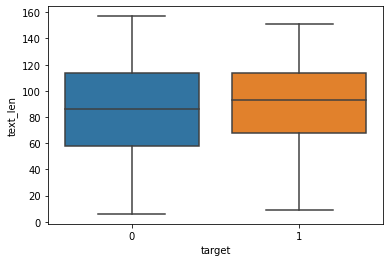

In [489]:
sns.boxplot(data=df, x="target", y="text_len") # 1 are slightly longer

<AxesSubplot:xlabel='text_len_bins', ylabel='text_len'>

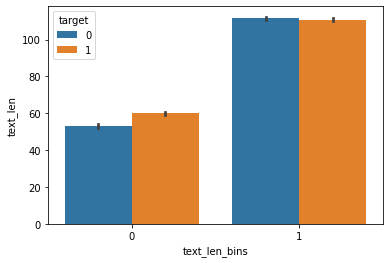

In [490]:
sns.barplot(data=df, x="text_len_bins",y="text_len",hue="target", orient="v") 
#distaster tweets are longer for bin one we created

<AxesSubplot:xlabel='target', ylabel='compound'>

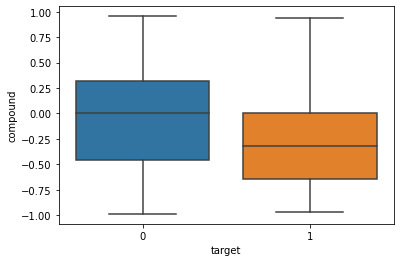

In [491]:
sns.boxplot(data=df, x="target", y="compound") #disaster tweets are clearly more proce to ha a negative compound sentiment

In [493]:
#visualizing keywords with most disaster labels
order = pd.crosstab(df["keyword+"], df.target).sort_values(1, ascending=False).index

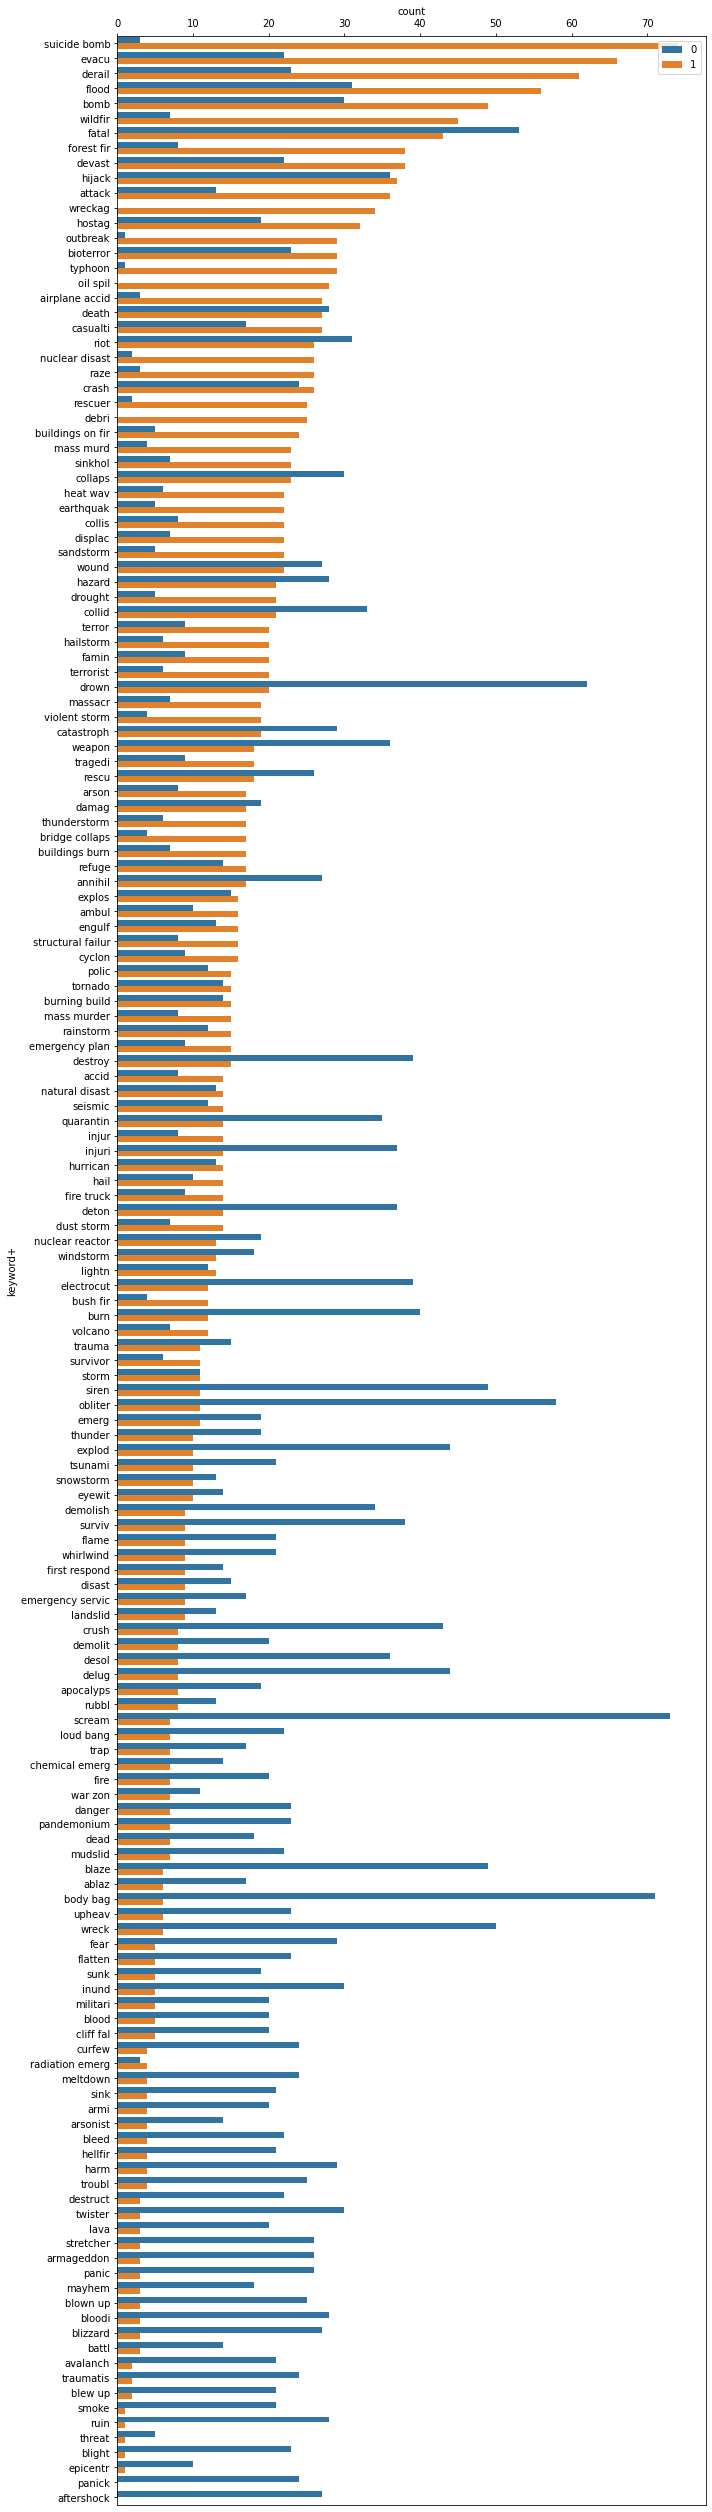

In [494]:
fig, ax = plt.subplots(figsize=(10,35)
                       )
ax = sns.countplot(data=df, y="keyword+", hue="target", orient="v", order = order)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.legend(loc='upper right')
plt.tight_layout()

<AxesSubplot:xlabel='has_ashtags', ylabel='count'>

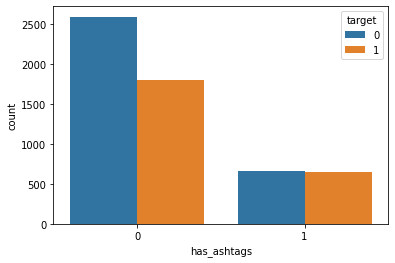

In [495]:
sns.countplot(data=df, x="has_ashtags", hue="target")
# not having an hashtag could be a discriminant for a disaster tweet

<AxesSubplot:xlabel='has_tag', ylabel='count'>

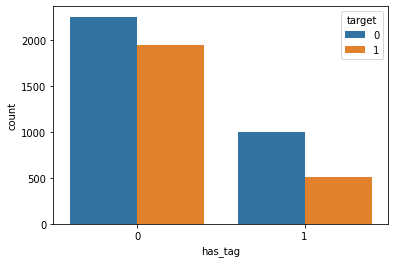

In [496]:
sns.countplot(data=df, x="has_tag", hue="target")
# a tag could be a discriminant eve tough we must take into account that the disaster tweets are less than non disaster

<AxesSubplot:xlabel='has_location', ylabel='count'>

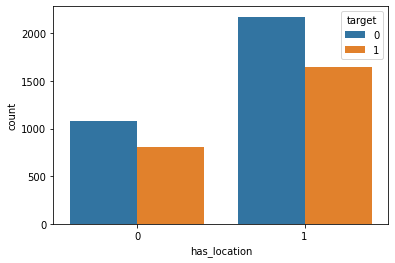

In [497]:
sns.countplot(data=df, x="has_location", hue="target")
# same as before

<AxesSubplot:xlabel='has_link', ylabel='count'>

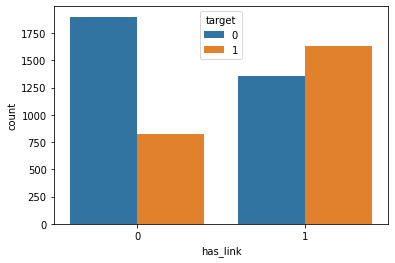

In [498]:
sns.countplot(data=df, x="has_link", hue="target")
# here we can see how having a link could be indicative of a disaster

In [499]:
kwd_transformer(X_valid)
text_transformer(X_valid)
location_transformer(X_valid)

removed space encoding
Imputed missing Keywords
made 'wild fires'=='wildfires' 
links done
len done
ashtags done
tags done
sentiment done


In [500]:
kwd_transformer(X_test)
text_transformer(X_test)
location_transformer(X_test)

removed space encoding
Imputed missing Keywords
made 'wild fires'=='wildfires' 
links done
len done
ashtags done
tags done
sentiment done


In [501]:
print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape, X_test.shape)

(5709, 13) (5709,) (1904, 13) (1904,) (3263, 13)


Changing categorical to numerical features:
1. One Hot Encode Keywords+
2. TD-IDF Vectorization fo the text feature to apply machine learning algorithm

In [503]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

#TRAIN
train_kwd_dummies = pd.DataFrame(encoder.fit_transform(X_train["keyword+"].values.reshape(-1,1))) #creating non sparse matrix
X_train.reset_index(inplace=True) #needs index to be resetted with concat

#concat
X_train = pd.concat([X_train, train_kwd_dummies], axis=1)

X_train.index = X_train["index"]
X_train.drop("index", axis=1, inplace=True)


In [505]:
valid_kwd_dummies = pd.DataFrame(encoder.transform(X_valid["keyword+"].values.reshape(-1,1)))

#VALID
X_valid.reset_index(inplace=True) #needs index to be resetted

#concat
X_valid = pd.concat([X_valid, valid_kwd_dummies], axis=1)

X_valid.index = X_valid["index"]
X_valid.drop("index", axis=1, inplace=True)

In [506]:
test_kwd_dummies = pd.DataFrame(encoder.transform(X_test["keyword+"].values.reshape(-1,1)))

#TEST
X_test.reset_index(inplace=True) #needs index to be resetted

#concat
X_test = pd.concat([X_test, test_kwd_dummies], axis=1)

X_test.index = X_test["index"]
X_test.drop("index", axis=1, inplace=True)

In [461]:
print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape, X_test.shape)

(5709, 178) (5709,) (1904, 178) (1904,) (3263, 343)


In [508]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Stem the text
    4. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    #Stem text
    stemmer = PorterStemmer()
    
    # Now just remove any stopwords
    return [stemmer.stem(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [509]:
#TRAINING
#vectorizing text columns
vectorizer = TfidfVectorizer(analyzer=text_process, min_df=5, max_df=0.5, ngram_range=(1,2))

train_text_tfidf = vectorizer.fit_transform(X_train['text'])

#making a dataframe to concatenate
train_text_tfidf = pd.DataFrame(train_text_tfidf.toarray()) #non sparse matrix

X_train.reset_index(inplace=True) #needs index to be resetted

#concat
X_train = pd.concat([X_train, train_text_tfidf], axis=1)

X_train.index = X_train["index"]
X_train.drop("index", axis=1, inplace=True)

In [510]:
#VALIDATION
valid_text_tfidf = vectorizer.transform(X_valid['text']) #avoid data leakage

#making a dataframe to concatenate
valid_text_tfidf = pd.DataFrame(valid_text_tfidf.toarray())

X_valid.reset_index(inplace=True) #needs index to be resetted

#concat
X_valid = pd.concat([X_valid, valid_text_tfidf], axis=1)

X_valid.index = X_valid["index"]
X_valid.drop("index", axis=1, inplace=True)

In [511]:
#TEST
test_text_tfidf = vectorizer.transform(X_test['text']) #avoid data leakage

#making a dataframe to concatenate
test_text_tfidf = pd.DataFrame(test_text_tfidf.toarray())

X_test.reset_index(inplace=True) #needs index to be resetted

#concat
X_test = pd.concat([X_test, test_text_tfidf], axis=1)

X_test.index = X_test["index"]
X_test.drop("index", axis=1, inplace=True)

Let's scale the compound feature first:

In [512]:
#scaling the compound feature
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [513]:
scaler.fit(X_train["compound"].values.reshape(-1,1))
# scaler.data_max_

MinMaxScaler()

In [515]:
X_train["compound"] = scaler.transform(X_train["compound"].values.reshape(-1,1))
X_valid["compound"] = scaler.transform(X_valid["compound"].values.reshape(-1,1))
X_test["compound"] = scaler.transform(X_test["compound"].values.reshape(-1,1))

In [516]:
def drop_columns(df):
   return df.drop(["keyword", "id", "ashtags", "location", "text_len", "keyword+", "text"], axis=1, inplace=True)

In [517]:
#dropping non necessary features
drop_columns(X_train)
drop_columns(X_valid)
drop_columns(X_test)

In [518]:
print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape, X_test.shape)

(5709, 2163) (5709,) (1904, 2163) (1904,) (3263, 2163)


In [389]:
#pca didn't give any improvement
# pca = PCA(n_components=6, random_state=42)

In [390]:

# X_train_pca = pca.fit_transform(X_train)
# X_valid_pca=pca.transform(X_valid)

In [391]:
# pca.explained_variance_
#only first 6 explain variance

array([0.30503408, 0.27026809, 0.2160117 , 0.1553367 , 0.14767732,
       0.05897002])

In [392]:
# print(X_train_pca.shape,y_train.shape, X_valid_pca.shape, y_valid.shape)

(5709, 6) (5709,) (1904, 6) (1904,)


# Model Evaluation

In [519]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1,random_state=42).fit(X_train, y_train)

In [520]:
prediction = clf.predict(X_valid)

In [521]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

print(confusion_matrix(y_valid, prediction))
print(accuracy_score(y_valid, prediction))
print(classification_report(y_valid, prediction))
print(f1_score(y_valid, prediction))


[[947 144]
 [222 591]]
0.8077731092436975
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904

0.7635658914728681


In [522]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)


In [523]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [524]:
prediction = rfc.predict(X_valid)

In [525]:
print(confusion_matrix(y_valid, prediction))
print(accuracy_score(y_valid, prediction))
print(classification_report(y_valid, prediction))
print(f1_score(y_valid, prediction))

[[970 121]
 [282 531]]
0.7883403361344538
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1091
           1       0.81      0.65      0.72       813

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.78      1904

0.724914675767918


In [526]:
from sklearn.svm import SVC
svm=SVC()

In [527]:
svm.fit(X_train,y_train)

SVC()

In [528]:
prediction = svm.predict(X_valid)

In [529]:
print(confusion_matrix(y_valid, prediction))
print(accuracy_score(y_valid, prediction))
print(classification_report(y_valid, prediction))
print(f1_score(y_valid, prediction))

[[969 122]
 [262 551]]
0.7983193277310925
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1091
           1       0.82      0.68      0.74       813

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904

0.7415881561238223


In [530]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [531]:
nb.fit(X_train,y_train)

MultinomialNB()

In [532]:
prediction = nb.predict(X_valid)

print(confusion_matrix(y_valid, prediction))
print(accuracy_score(y_valid, prediction))
print(classification_report(y_valid, prediction))
print(f1_score(y_valid, prediction))

[[917 174]
 [227 586]]
0.789390756302521
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1091
           1       0.77      0.72      0.75       813

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904

0.7450731087094723


Random Forest performed slightly better than the onthers classifiers. We will fine tune this model:

In [533]:
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [534]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10)

results = cross_validate(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=kfold,
                            scoring=scoring)


print("Accuracy: {:.2f} %".format(results["test_accuracy"].mean()*100))
print("Standard Deviation: {:.2f} %".format(results["test_accuracy"].std()*100))
print("F1_score: {:.2f} %".format(results["test_f1_score"].mean()*100))
print("Precision: {:.2f} %".format(results["test_precision"].mean()*100))
print("Recall: {:.2f} %".format(results["test_recall"].mean()*100))


Accuracy: 78.96 %
Standard Deviation: 1.58 %
F1_score: 74.03 %
Precision: 78.97 %
Recall: 69.69 %


In [535]:
parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]
grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           n_jobs = -1,
                           verbose=2)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best f1: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best f1: 73.63 %
Best Parameters: {'C': 1}


In [537]:
test_prediction = clf.predict(X_test)

In [539]:
test_prediction

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [545]:
submission = pd.DataFrame({'id': pd.read_csv("test.csv").id.values,
                           'target': test_prediction})


In [547]:
submission.to_csv("submission.csv", index=False)

In [548]:
len(submission)

3263